In [1]:
### First we handle our files ###
BASE_PATH = "../data"
FILE = "294_737_599"
tree_path = f"{BASE_PATH}/{FILE}.tree"
alignment_path = f"{BASE_PATH}/{FILE}.fas.alg"
table_path = f"{BASE_PATH}/{FILE}.tsv"
uniprot_path = f"../uniprot_2018_09.json"

### And we store them in different variables ###
try:
    with open(table_path, "r") as table_file:
        table_info = table_file.readlines()
    table_file.close()
except:
    print ("No table path.")
        
try:
    with open(alignment_path, "r") as alignment_file:
        alignment_info = alignment_file.read()
    alignment_file.close()
except:     
    print ("No alignment path.")
        
import json
uniprot_info = {}
with open(uniprot_path, "r") as uniprot_file:
    for line in uniprot_file:
        uniprot_entry = json.loads(line)
        uniprot_info.update(uniprot_entry)
    uniprot_file.close

In [110]:
### LOADING THE SPECIFIED TAG INFORMATION FROM OUR ALIGNMENT ###
def retrieve_features (feature_tag, table_file, evalue_threshold):
    uniprot_hit_hash = {}
    saving_list = []
    
    for line in table_file:
        hit_type = line.split("\t")[2]
        hit_name = line.split("\t")[3]
        hit_evalue = line.split("\t")[4]
        
        if hit_evalue == "-":
            hit_evalue = 0.0
        else:
            hit_evalue = float(hit_evalue)

        if (hit_type == ("spb" or "spe") and 
            hit_name not in uniprot_hit_hash and 
            hit_evalue <= evalue_threshold):
            features_newlist = []
#             for feature in uniprot_info[hit_name]["FT"]: # TO CHECK FEATURES WHEN WE PICK A NEW FILE MANUALLY
#                 print (feature)
            for feature in uniprot_info[hit_name]["FT"]:
                if feature["ft"] == feature_tag:
                    features_newlist.append(feature)
            if len(features_newlist) > 0:
                uniprot_hit_hash[hit_name] = features_newlist
            saving_list.append(hit_name)
    saving_list = set(saving_list)
    return uniprot_hit_hash, saving_list

In [111]:
uniprot_hit_hash, leaf_save_list = retrieve_features("BINDING", table_info, 1e-250)
print (uniprot_hit_hash)
print (leaf_save_list)

{'A3CL77': [{'ft': 'BINDING', 's': '109', 'e': '109', 'ann': 'Substrate. {ECO:0000255|HAMAP-Rule:MF_00087}.'}, {'ft': 'BINDING', 's': '120', 'e': '120', 'ann': 'Substrate. {ECO:0000255|HAMAP-Rule:MF_00087}.'}]}
{'A3CL77'}


In [18]:
### LOADING THE TREE WITH ETE3 ###    
from ete3 import PhyloTree, TreeStyle, SeqMotifFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")

In [5]:
### TRANSFORMING THE SEQUENCE POSITIONS INTO ALIGNMENTS POSITIONS ###
def get_alignment_position (sequence_position, sequence):
    alignment_position = 0
    aminoacid_counted = 0
    for aminoacid in sequence:
        if aminoacid.isalpha():
            aminoacid_counted += 1
        if not (aminoacid_counted <= sequence_position or aminoacid_counted == 0):
            break
        alignment_position += 1
    return alignment_position

In [6]:
### GETTING A POSITIONS MATRIX FROM THE FEATURES IN OUR TREE ###
def get_positions_matrix (feature_hash, tree):
    position_matrix = []
    for unigene in feature_hash:
        unigene_sequence = (tree&unigene).sequence
        for feature in feature_hash[unigene]:
            feature_start = int(feature["s"])-1
            feature_end = int(feature["e"])-1
            alignment_feature_start = get_alignment_position(feature_start, unigene_sequence)
            alignment_feature_end = get_alignment_position(feature_end, unigene_sequence)
            for position in range (alignment_feature_start, alignment_feature_end+1):
                position_matrix.append(position)
    position_matrix = sorted(list(set(position_matrix)))
    return position_matrix

In [80]:
position_matrix = get_positions_matrix(uniprot_hit_hash, tree)
print (position_matrix)

[1008, 1019]


In [8]:
import itertools

def simple_calculus (aminoacid_matrix):
    position_means = []
    for position_aminoacids in aminoacid_matrix:
        position_comparison = []
        for aa1, aa2 in itertools.combinations(position_aminoacids, 2):
            if aa1 == aa2:
                position_comparison.append(1)
            else:
                position_comparison.append(0)
        position_means.append(sum(position_comparison)/len(position_comparison))
    score = sum(position_means)/len(position_means)    
    return score

In [9]:
def calculate_node_score (node, position_matrix, calculus_algorithm):
    aminoacid_matrix = []
    for position in position_matrix:
        position_aminoacids = []
        for leaf in node.iter_leaves():
            position_aminoacids.append(leaf.sequence[position])
        aminoacid_matrix.append(position_aminoacids)

    if calculus_algorithm == "simple":
        score = simple_calculus(aminoacid_matrix)
    return score

In [38]:
# Calculating scores for internal nodes
node_number = 0
node_scores = {}

for node in tree.traverse():
    if node.is_leaf() == False:
        node_score = round(calculate_node_score(node, position_matrix, "simple"), 2)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1

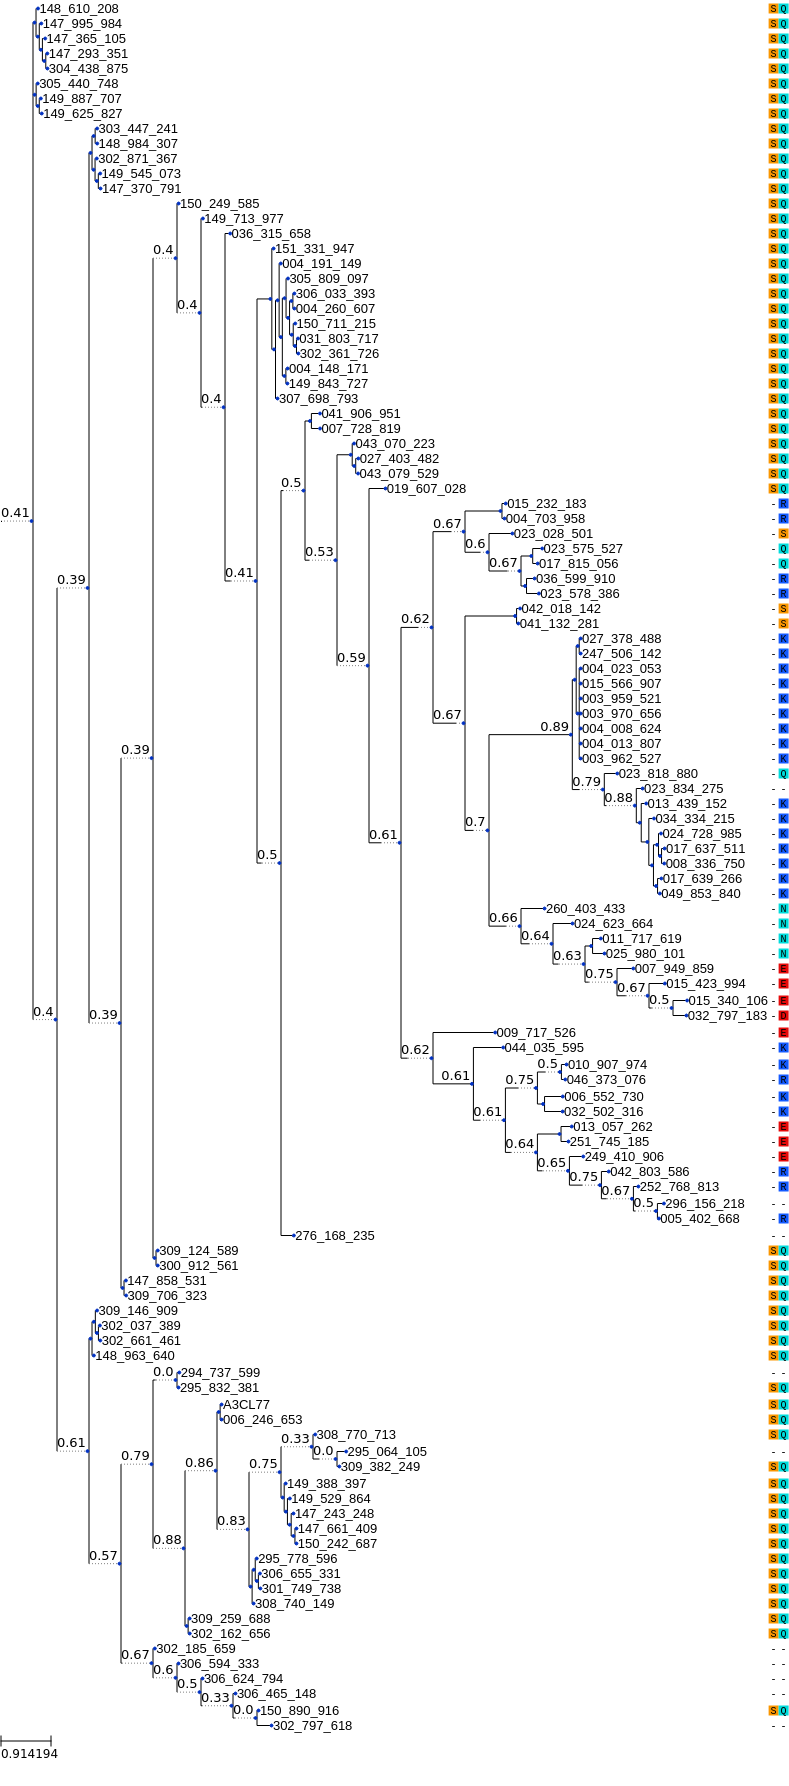

In [115]:
### VISUALIZING THE TREE ###
from ete3 import PhyloTree, TreeStyle, SeqMotifFace, TextFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")

import re

ts = TreeStyle()
ts.layout_fn = lambda x: True

node_number = 0
node_scores = {}

for leaf in tree.iter_leaves():
    leaf_name_match = re.match( r'\d{3}_\d{3}_\d{3}', leaf.name)
    if not (leaf.name in leaf_save_list or leaf_name_match):
        leaf.delete()
        
for node in tree.traverse():
    if node.is_leaf() == True:
        draw_position = 0
        for position in position_matrix:
            seqFace = SeqMotifFace(node.sequence[position], seq_format="seq")
            (tree&node.name).add_face(seqFace, draw_position, "aligned")
            draw_position += 1  
    else:
        node_score = round(calculate_node_score(node, position_matrix, "simple"), 2)
        node.add_feature("node_score", node_score)
        node_scores[node_number] = node_score
        node_number += 1
        if node_score < 1.0:
            score_face = TextFace(node.node_score)
            node.add_face(score_face, 0, "branch-top")
        

# tree.render("mytree.png", w=800, h=2000, units="px", tree_style=ts)
tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)

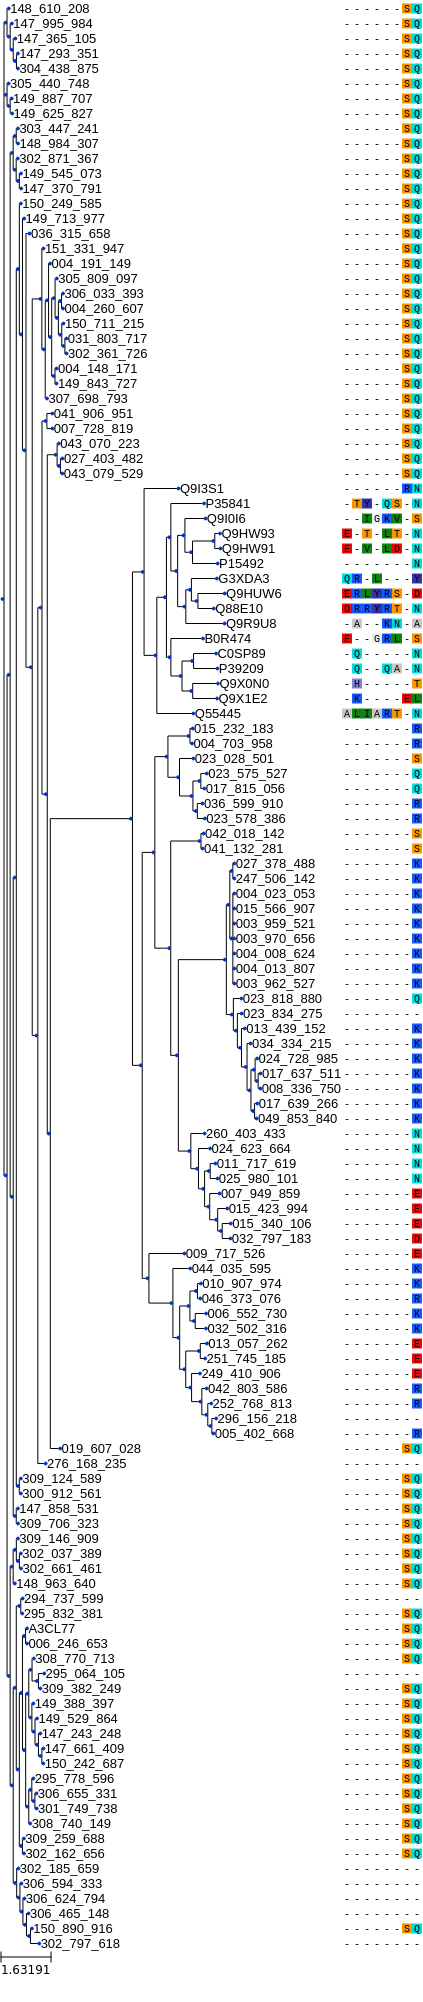

In [19]:
### VISUALIZING THE TREE ###
from ete3 import PhyloTree, TreeStyle, SeqMotifFace
tree = PhyloTree(tree_path, alignment=alignment_info, alg_format="fasta")

ts = TreeStyle()
ts.layout_fn = lambda x: True

for leaf in tree.iter_leaves():
    draw_position = 0
    for position in position_matrix:
        seqFace = SeqMotifFace(leaf.sequence[position], seq_format="seq")
        (tree&leaf.name).add_face(seqFace, draw_position, "aligned")
        draw_position += 1

tree.render('%%inline', tree_style = ts)
# tree.show(tree_style = ts)